In [6]:
import sys
import os
from selenium import webdriver
import json
from PIL import Image
import pytesseract
import time
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from ReportMonitor_UI import Ui_MainWindow
import threading
from win10toast import ToastNotifier
from Notification import send_notification
from collections import defaultdict
import winsound
import string
import importlib

In [3]:
# driver.get("http://" + goalurl + "/pyxx/login.aspx")
# driver.maximize_window()
# current_window_size = driver.get_window_size()
# width = current_window_size["width"]
# height = current_window_size["height"]
# driver.set_window_size(width, height)
# aElement = driver.find_element_by_xpath('./*//title')
# print(aElement.get_attribute("innerText"))

In [4]:
user = "2017400144"
goalurl = "yjsy.buct.edu.cn:8080"
url = "http://" + goalurl + "/pyxx/txhdgl/hdlist.aspx?xh=" + user

In [5]:
option = webdriver.ChromeOptions()
option.add_argument("--start-maximized")
option.add_argument('window-size=1536, 824')
option.add_argument('headless')

driver = webdriver.Chrome(options=option)
driver.get(url)
target = driver.find_element_by_xpath("./*//input[@name='txtyzm']/../img")
driver.execute_script("arguments[0].scrollIntoView(false);", target)  # 拖动到可见的元素去

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"./*//input[@name='txtyzm']/../img"}
  (Session info: headless chrome=90.0.4430.72)


In [ ]:

yzmElement = driver.find_element_by_xpath("./*//input[@name='txtyzm']/../img")
img = Image.open('screenshot.png')

left = int(yzmElement.location['x'])

# top = int(yzmElement.location['y'])
# top = img.height - 32 - yzmElement.size['height'] #- bottomTable.size['height']
if int(yzmElement.location['y'] + yzmElement.size['height']) > img.height:
    bottom = img.height
else:
    bottom = int(yzmElement.location['y'] + yzmElement.size['height'])
top = bottom - yzmElement.size['height']
right = int(yzmElement.location['x'] + yzmElement.size['width'])
# bottom = int(yzmElement.location['y'] + yzmElement.size['height'])
print((left, top, right, bottom))
img = img.crop((left, top, right, bottom))
img.save('code.png')

In [ ]:
def _get_threshold(image):
    pixel_dict = defaultdict(int)

    #  a dictionary of pixels and the number of occurrences of that pixel
    rows, cols = image.size
    for i in range(rows):
        for j in range(cols):
            pixel = image.getpixel((i, j))
            pixel_dict[pixel] += 1

    count_max = max(pixel_dict.values())  # gets the number of times a pixel appears
    pixel_dict_reverse = {v: k for k, v in pixel_dict.items()}
    threshold = pixel_dict_reverse[count_max]  #

    return threshold

def _get_bin_table(threshold):
    table = []
    for i in range(256):
        rate = 0.1  # threshold
        if threshold * (1 - rate) <= i <= threshold * (1 + rate):
            table.append(1)
        else:
            table.append(0)
    return table

def _cut_noise(image):
    rows, cols = image.size  #
    change_pos = []  #
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            pixel_set = []
            for m in range(i - 1, i + 2):
                for n in range(j - 1, j + 2):
                    if image.getpixel((m, n)) != 1:  # 1,0
                        pixel_set.append(image.getpixel((m, n)))
            if len(pixel_set) <= 4:
                change_pos.append((i, j))
    for pos in change_pos:
        image.putpixel(pos, 1)
    return image

In [ ]:
image = Image.open('code.png')
image = image.convert('L')
max_pixel = _get_threshold(image)
table = _get_bin_table(threshold=max_pixel)
image = image.point(table, '1')
image = _cut_noise(image)
image.save('code_denoise.png')
yzm = pytesseract.image_to_string(image)
# exclude_char_list = ' .·:`‘、“\\|\'\"?![],()~@#$%^&*_+-={};<>/¥'
# yzm = ''.join([x for x in yzm if x not in exclude_char_list]).strip()

print(yzm)

whitespace = ['\f', '\n', '\r', '\t', '\v', '\u00A0', '\u2028', '\u2029']
yzm = ''.join(filter(lambda x: x not in whitespace, filter(lambda x: x in string.printable, yzm))).strip(' \r\n\f\t\b\v\0')

print(yzm)

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("code.png")
cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_img = cv2.inRange(cv2_img, lowerb=160, upperb=255)
pil_img = Image.fromarray(cv2_img)
pil_img = pil_img.convert('L')
pil_img.show()


plt.subplot(121), plt.imshow(img)  # 原始图片
plt.subplot(122), plt.imshow(pil_img)  # 降噪图片
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from PIL import Image
# pil_img = Image.open('code.png')
# pil_img = pil_img.convert('L')
# pil_img.show()
# cv2_img = np.asarray(pil_img)
# cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_RGB2GRAY)
#
# plt.subplot(121), plt.imshow(pil_img)  # 原始图片
# plt.subplot(122), plt.imshow(cv2_img)  # 降噪图片
# plt.show()

In [2]:
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import os


im1 = cv2.imread('code.png')  # 读入图片
im_gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)   # 将图片转成灰度图
# 报错 error: (-215:Assertion failed) 原因是文件路径错误
ret1, im_inv1 = cv2.threshold(im_gray1, 127, 255, cv2.THRESH_BINARY_INV)  # 二值化
# 应用高斯模糊对图片进行降噪，高斯模糊的本质是用高斯核和图像做卷积
kernel1 = 1/16*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
im_blur1 = cv2.filter2D(im_inv1, -1, kernel1)

# 降噪后再做一轮二值化处理
ret2, im_inv2 = cv2.threshold(im_blur1, 127, 255, cv2.THRESH_BINARY)

# 把最开始的图片切割成单个字符
# 第一步 用opencv的findContours来提取轮廓 （cv2.findContours()函数接受的参数为二值图）
contours, hierarchy = cv2.findContours(im_inv2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 第一个参数是寻找轮廓的图像，第二个参数表示轮廓的检索模式，第三个参数method为轮廓的近似办法
cv2.drawContours(im1, contours, -1, (0, 255, 0), 1)  # 第三个参数为线条颜色，第四个参数线条粗度
cv2.namedWindow("im1_drawContour")
cv2.imshow("im1_drawContour", im1)
cv2.waitKey(50)

-1

In [3]:
dfContourShape = pd.DataFrame(columns=('X','Y','W','H'))
for i in range(len(contours)):
    # cv2.drawContours(cv2.imread(filepath1) , contours, i, (0, 255, 0), 1)   # i 表示绘制第i条轮廓
    x, y, w, h = cv2.boundingRect(contours[i])  # 用一个最小的矩形，把找到的形状包起来
    dfContourShape = dfContourShape.append([{'X': x, 'Y':y, 'W':w, 'H':h}], ignore_index=True)
    im3 = cv2.rectangle(im1, (x, y), (x + w, y + h), (0, 0, 255), 2)
    # cv2.namedWindow("im3")
    # cv2.imshow("im3", im3)
    # cv2.waitKey(50)
    # cv2.destroyAllWindows()
result = []
for i in range(len(dfContourShape)):
    x = dfContourShape['X'][i]
    y = dfContourShape['Y'][i]
    w = dfContourShape['W'][i]
    h = dfContourShape['H'][i]
    wMax = max(dfContourShape['W'])
    wMin = min(dfContourShape['W'])
    if len(dfContourShape) == 1:
        boxLeft = np.int0([[x, y], [x + w / 4, y], [x + w / 4, y + h], [x, y + h]])
        boxMidLeft = np.int0([[x + w / 4, y], [x + w * 2 / 4, y], [x + w * 2 / 4, y + h], [x + w / 4, y + h]])
        boxMidRight = np.int0([[x + w * 2 / 4, y], [x + w * 3 / 4, y], [x + w * 3 / 4, y + h], [x + w * 2 / 4, y + h]])
        boxRight = np.int0([[x + w * 3 / 4, y], [x + w, y], [x + w, y + h], [x + w * 3 / 4, y + h]])
        result.extend([boxLeft, boxMidLeft, boxMidRight, boxRight])
    elif len(dfContourShape) == 2:  # 两种情况
        # 如果一个轮廓的宽度是另一个的2倍以上，这个轮廓大概率是包含3个字符的轮廓
        if wMax >= wMin * 2:
            if w == wMax:
                box_left = np.int0([[x,y], [x+w/3,y], [x+w/3,y+h], [x,y+h]])
                box_mid = np.int0([[x+w/3,y], [x+w*2/3,y], [x+w*2/3,y+h], [x+w/3,y+h]])
                box_right = np.int0([[x+w*2/3,y], [x+w,y], [x+w,y+h], [x+w*2/3,y+h]])
                result.append(box_left)
                result.append(box_mid)
                result.append(box_right)
            else:
                box = np.int0([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])
                result.append(box)
        # 如果两个轮廓，较宽的宽度小于较窄的2倍，大概率这是两个包含2个字符的轮廓
        else:
            box_left = np.int0([[x,y], [x+w/2,y], [x+w/2,y+h], [x,y+h]])
            box_right = np.int0([[x+w/2,y], [x+w,y], [x+w,y+h], [x+w/2,y+h]])
            result.append(box_left)
            result.append(box_right)
    elif len(dfContourShape) == 3:
        if w == wMax:
            # w_max是所有 contonur 的宽度中最宽的值
            box_left = np.int0([[x,y], [x+w/2,y], [x+w/2,y+h], [x,y+h]])
            box_right = np.int0([[x+w/2,y], [x+w,y], [x+w,y+h], [x+w/2,y+h]])
            result.append(box_left)
            result.append(box_right)
        else:
            box = np.int0([[x,y], [x+w,y], [x+w,y+h], [x,y+h]])
            result.append(box)
    elif len(dfContourShape) == 4:
        box = np.int0([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])
        result.append(box)
    elif len(dfContourShape) == 5:
        if w != wMin:
            box = np.int0([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])
            result.append(box)
    else:
        print('分割轮廓数大于 5 切换验证码!')
if len(result) != 4:
    print('len(result) != 4 .....\nlen(result) != 4 .....\nlen(result) != 4 .....')

for box in result:
    cv2.drawContours(cv2.imread('code.png'), [box], 0, (0, 0, 255), 1)
    cv2.namedWindow("im1")
    cv2.imshow("im1", im1)
    cv2.waitKey(100)  # 100毫秒
    time.sleep(3)
    cv2.destroyAllWindows()
    roi = im_inv2[box[0][1]:box[3][1], box[0][0]:box[1][0]]
    roiStd = cv2.resize(roi, (30, 30))
    # 将字符图片统一调整为30x30的图片大小
    # 为防止文件重名，使用时间戳命名文件名

In [10]:
cv2.imwrite('./', roiStd)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:682: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [17]:
img = cv2.imread('code.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite("gray.png", img)
# img = cv2.adaptiveThreshold(img, 127, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
ret1, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("threshold.png", img)
kernel = 1/16*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
img = cv2.dilate(img, kernel, iterations=20)
img = cv2.erode(img, kernel, iterations=20)
img = cv2.filter2D(img, -1, kernel1)
ret2, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("no_noise.png", img)


code = pytesseract.image_to_string(Image.open("no_noise.png"))

print(code)

In [21]:
import re
img = cv2.imread('code.png')

# blur = cv2.GaussianBlur(img, (3, 3), 0)  # 高斯滤波函数
# blur = cv2.medianBlur(img, 3)  # 中值滤波函数
blur = cv2.bilateralFilter(img, 3, 560, 560)  # 双边滤波函数

a = pytesseract.image_to_string(blur)

# 对结果的处理
st = re.sub(r'[^A-Za-z0-9]+', '', a)
st = st.lower()
if len(st) > 4:
    b = st[-4:]
else:
    b = st
print(st)

KeyboardInterrupt: 

In [22]:
import sys, os
from PIL import Image, ImageDraw

t2val = {}
def twoValue(image, G):
    for y in range(0, image.size[1]):
        for x in range(0, image.size[0]):
            g = image.getpixel((x, y))
            if g > G:
                t2val[(x, y)] = 1
            else:
                t2val[(x, y)] = 0


# 根据一个点A的RGB值，与周围的8个点的RBG值比较，设定一个值N（0 <N <8），当A的RGB值与周围8个点的RGB相等数小于N时，此点为噪点
# G: Integer 图像二值化阀值
# N: Integer 降噪率 0 <N <8
# Z: Integer 降噪次数
# 输出
#  0：降噪成功
#  1：降噪失败
def clearNoise(image, N, Z):
    for i in range(0, Z):
        t2val[(0, 0)] = 1
        t2val[(image.size[0] - 1, image.size[1] - 1)] = 1

        for x in range(1, image.size[0] - 1):
            for y in range(1, image.size[1] - 1):
                nearDots = 0
                L = t2val[(x, y)]
                if L == t2val[(x - 1, y - 1)]:
                    nearDots += 1
                if L == t2val[(x - 1, y)]:
                    nearDots += 1
                if L == t2val[(x - 1, y + 1)]:
                    nearDots += 1
                if L == t2val[(x, y - 1)]:
                    nearDots += 1
                if L == t2val[(x, y + 1)]:
                    nearDots += 1
                if L == t2val[(x + 1, y - 1)]:
                    nearDots += 1
                if L == t2val[(x + 1, y)]:
                    nearDots += 1
                if L == t2val[(x + 1, y + 1)]:
                    nearDots += 1

                if nearDots < N:
                    t2val[(x, y)] = 1


image = Image.open('code.png').convert("L")
twoValue(image, 100)
clearNoise(image, 2, 1)
image.save('new.png')

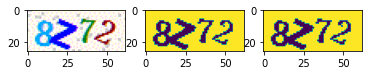

In [41]:
import cv2, time
import matplotlib.pyplot as plt

# 计算邻域非白色个数
def calculate_noise_count(img_obj, w, h):
    """
    计算邻域非白色的个数
    Args:
        img_obj: img obj
        w: width
        h: height
    Returns:
        count (int)
    """
    count = 0
    width, height,s = img_obj.shape
    for _w_ in [w - 1, w, w + 1]:
        for _h_ in [h - 1, h, h + 1]:
            if _w_ > width - 1:
                continue
            if _h_ > height - 1:
                continue
            if _w_ == w and _h_ == h:
                continue
            if (img_obj[_w_, _h_,0] < 233) or (img_obj[_w_, _h_,1] < 233) or (img_obj[_w_, _h_,2] < 233):
                count += 1
    return count


# k邻域降噪
def operate_img(img,k):
    w,h,s = img.shape
    # 从高度开始遍历
    for _w in range(w):
        # 遍历宽度
        for _h in range(h):
            if _h != 0 and _w != 0 and _w < w-1 and _h < h-1:
                if calculate_noise_count(img, _w, _h) < k:
                    img.itemset((_w,_h,0),255)
                    img.itemset((_w, _h,1), 255)
                    img.itemset((_w, _h,2), 255)

    return img


img = cv2.imread("code.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img2 = cv2.inRange(gray, lowerb=180, upperb=255)
# cv2.namedWindow("im1")
# cv2.imshow("im1", img2)
# cv2.waitKey(100)  # 100毫秒
# time.sleep(3)
# cv2.destroyAllWindows()

# ret, img3 = cv2.threshold(img2, 160, 255, cv2.THRESH_BINARY)
img3 = cv2.adaptiveThreshold(img2, 180, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
plt.subplot(131), plt.imshow(img)  # 原始图片
plt.subplot(132), plt.imshow(img2)  # 降噪图片
plt.subplot(133), plt.imshow(img3)
plt.show()